# Pytorch sucks am I right?

In [1]:
import os
import re
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# TPU Config

In [2]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Helper Functions
### Import and clean data

Helper function `clean` to remove IP addresses, datetimes, https addresses and usernames.

In [3]:
def clean(text):
    text = re.sub(r'[0-9"]', '', text)
    text = re.sub(r'#[\S]+\b', '', text)
    text = re.sub(r'@[\S]+\b', '', text)
    text = re.sub(r'https?\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [4]:
def encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts,
        return_attention_masks=False,
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    return np.array(enc_di['input_ids'])

## Loading Data

In [5]:
kaggle = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'
train1 = pd.read_csv(f'{kaggle}jigsaw-toxic-comment-train.csv')
train2 = pd.read_csv(f'{kaggle}jigsaw-unintended-bias-train.csv')
valid = pd.read_csv(f'{kaggle}validation.csv')
test = pd.read_csv(f'{kaggle}test.csv')

In [6]:
train1['comment_text'] = train1['comment_text'].apply(clean)
train2['comment_text'] = train2['comment_text'].apply(clean)
train2['toxic'] = train2.toxic.round().astype(int)
valid['comment_text'] = valid['comment_text'].apply(clean)
test['content'] = test['content'].apply(clean)

In [7]:
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=0)
])

# Data Visualizations

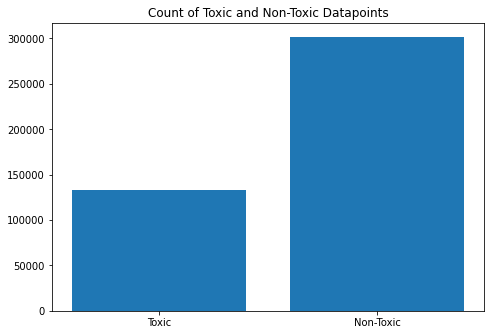

In [8]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title('Count of Toxic and Non-Toxic Datapoints')
labels = ['Toxic', 'Non-Toxic']
values = [len(train[train['toxic']==1]), len(train[train['toxic']==0])]
ax.bar(labels, values)
plt.show()

# Tokenization
Using XLM-Roberta (Base)

In [9]:
tokenizer = transformers.AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')

In [10]:
%%time

x_train = encode(train.comment_text.values, tokenizer, maxlen=192)
x_valid = encode(valid.comment_text.values, tokenizer, maxlen=192)
x_test = encode(test.content.values, tokenizer, maxlen=192)

CPU times: user 7min 26s, sys: 2.36 s, total: 7min 28s
Wall time: 7min 28s


Save tokenized IDs seperate from the toxic labels.

# Create Embeddings

In [11]:
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
        .from_tensor_slices(x_train)
        .batch(128)
        .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
        .from_tensor_slices(x_valid)
        .batch(128)
        .cache()
        .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
        .from_tensor_slices(x_test)
        .batch(128)
)

In [12]:
def build(transformer, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_word_ids")
    cls_token = transformer(input_ids)[0][:,0,:]
    out = tf.reshape(cls_token, [-1, cls_token.shape[1], 1])
    model = Model(inputs=input_ids, outputs=out)
    model.compile(Adam(lr=1e-5), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
%%time
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('jplu/tf-xlm-roberta-large')
    model = build(transformer_layer, maxlen=192)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 192, 1024), (None 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
tf_op_layer_Reshape (TensorF [(None, 1024, 1)]         0         
Total params: 559,890,432
Trainable params: 559,890,432
Non-trainable params: 0
_________________________________________________________________
CPU times: user 1min 52s, sys: 46.6 s, total: 2min 38s
Wall time: 2min 34s


In [14]:
x_train = model.predict(train_dataset, verbose=1)[0:len(x_train)]
x_valid = model.predict(valid_dataset, verbose=1)[0:len(x_valid)]
x_test = model.predict(test_dataset, verbose=1)[0:len(x_test)]

499/499 [==============================] - 95s 190ms/step


# Seperating Training Data into Several Files

In [15]:
np.save('x_train', x_train)
np.save('x_valid', x_valid)
np.save('x_test', x_test)

In [16]:
np.save('y_train', train.toxic.values)
np.save('y_valid', valid.toxic.values)